In [2]:
import matplotlib
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
from theano import tensor as tt, function, scan, shared

from rl.agent import Agent, AgentVars
from rl.task import ReversalLearningTask, TaskVarsKahntPark2008
from rl.interaction import agent_task_interaction
from rl.plots import plot_data
from rl.plot_utils import set_mpl_defaults

set_mpl_defaults(matplotlib)
theano.config.compute_test_value = 'off' # Use 'warn' to activate this feature

import warnings
warnings.filterwarnings("ignore")

# Simulate data

In [5]:
# Agent setup
agent_vars = AgentVars()
agent_vars.alpha_win = 0.5
agent_vars.alpha_loss = 0.2
agent_vars.beta = 5
agent = Agent(agent_vars)
agent

Dual learning rate agent with
  alpha_win = 0.5
  alpha_loss = 0.2
  beta = 5

In [6]:
# Task setup
task_vars = TaskVarsKahntPark2008()
task_vars.n_trials = 200
task_vars.n_blocks = 1
task = ReversalLearningTask(task_vars)
task

Reversal learning task with the states (rules):
  {'0': {'p_r': array([0.2, 0.8]), 'a_correct': [1]}, '1': {'p_r': array([0.8, 0.2]), 'a_correct': [0]}, '2': {'p_r': array([0.5, 0.5]), 'a_correct': [0, 1]}}

In [7]:
# Let the agent perform the task
df = agent_task_interaction(task, agent)
df.head()

,trial,block,state,p_r_0,p_r_1,r,a,corr,p_a_0,v_a_0,p_a_1,v_a_1,ll
0,0.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.500000,0.0,0.500000,0.5000,-0.693147
1,1.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.075858,0.0,0.924142,0.7500,-0.078890
2,2.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.022977,0.0,0.977023,0.8750,-0.023245
3,3.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,0.012432,0.0,0.987568,0.9375,-0.012510
4,4.0,0.0,0.0,0.2,0.8,0.0,1.0,1.0,0.009126,0.0,0.990874,0.7500,-0.009168


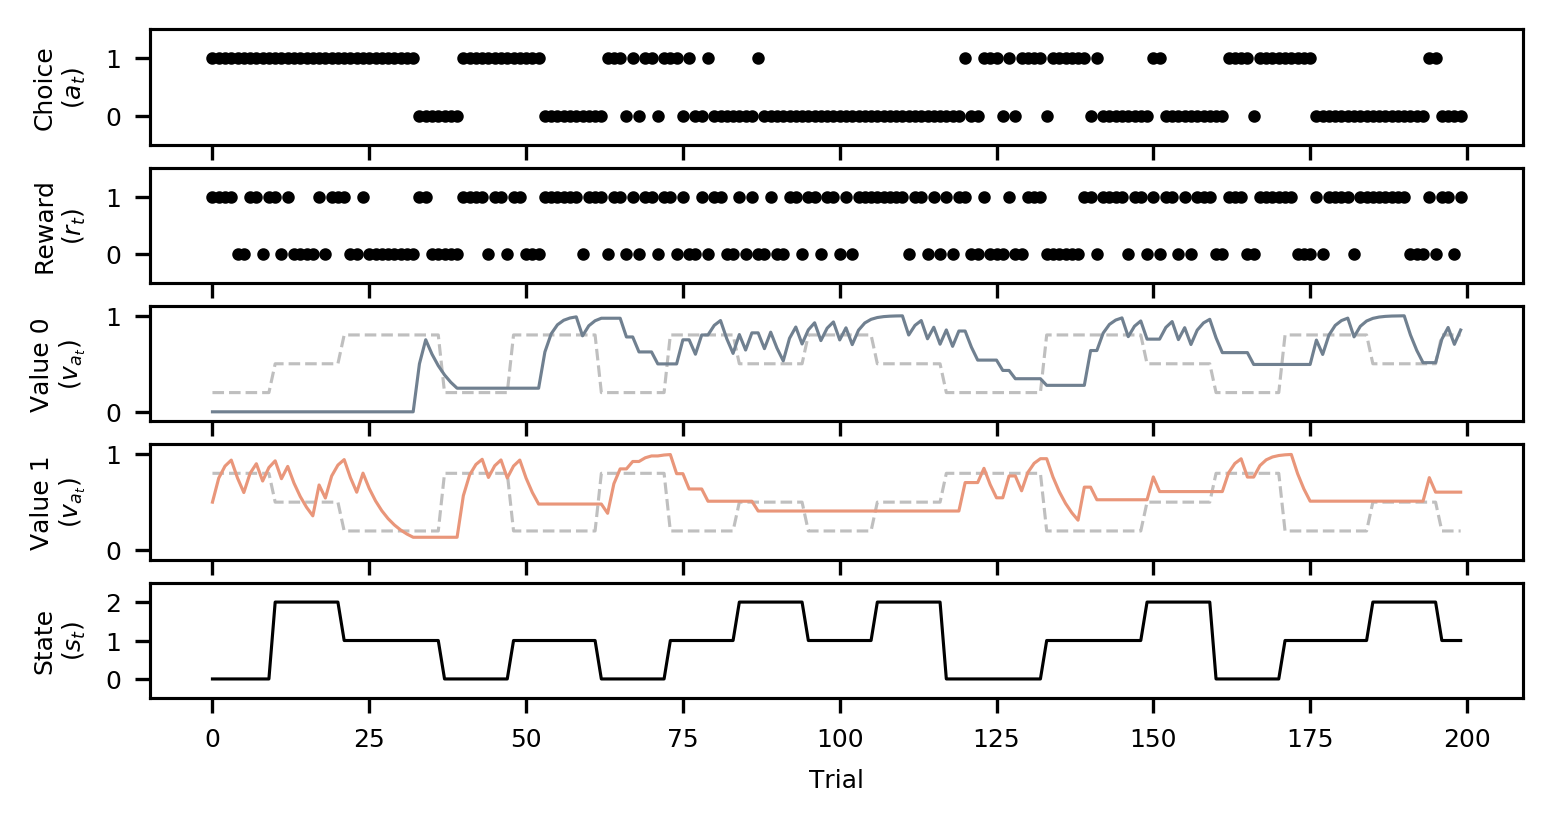

In [8]:
plot_data(df);

# PyMC3 implementation

## Learning functions

In [9]:
# Simple Rescorla Wagner model functions, with one single learning rate
# We actually do not use these below.

def RW_learn(r_t, a_t, v_t, alpha):
    """Simple RW learning rule.
    
    Args:
        r_t (float): current reward
        a_t (int): current action
        v_t (numpy.array): current values
        alpha (float): learning rate
    """
    # arg order in scan is: sequences (if any), prior result(s) (if needed), non-sequences (if any)
    delta = r_t - v_t[a_t]
    v_a_tplus1 = v_t[a_t] + alpha * delta
    v_tplus1 = tt.set_subtensor(v_t[a_t], v_a_tplus1)
    return v_tplus1

def tt_RW_compute_vs(r, a, alpha, v0):
    """Theano tensor implementation of the RW model's learning over all trials.
    
    Args:
        r (1d tensor): rewards
        a (1d tensor): actions
        alpha (float): learning rate
        v0 (1d tensor): initial valuation

    Returns:
        2d tensor: matrix of valuations (n_trials x n_options)
    """
    v_new, update = scan(
        lambda r, a, v, alpha: RW_lean(r, a, v, alpha),
        sequences=[r, a],
        non_sequences=[alpha],
        outputs_info=[v0])
    return v_new

In [10]:
# Rescorla Wagner Win Loss (RWwl) functions.
# The first function implements a single learning step
# The second function implements learning over all trials, for a given set of parameters and data.

def RWwl_learn(r_t, a_t, v_t, alpha_win, alpha_loss):
    """RW learning rule with two learning rates:
        alpha_win:  Following positive rewards (r=1)
        alpha_loss: Following negative rewards (r=0)
    The model is described in Kahnt, Park et al. (2008)
    
    Args:
        r_t (float): current reward
        a_t (int): current action
        v_t (numpy.array): current values
        alpha_win (float): learning rate for positive rewards
        alpha_loss (float): learning rate for negative rewards
    """
    # arg order in scan is: sequences (if any), prior result(s) (if needed), non-sequences (if any)
    delta = r_t - v_t[a_t]
    alpha = tt.switch(tt.lt(delta, 0), alpha_loss, alpha_win)
    v_a_tplus1 = v_t[a_t] + alpha * delta
    v_tplus1 = tt.set_subtensor(v_t[a_t], v_a_tplus1)
    return v_tplus1

def tt_RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0):
    """Theano tensor implementation of the RW model's learning over all trials.
    
    Args:
        r (1d tensor): rewards
        a (1d tensor): actions
        alpha_win (float): learning rate for wins
        alpha_loss (float): learning rate for losses
        v0 (1d tensor): initial valuation

    Returns:
        2d tensor: matrix of valuations (n_trials x n_options)
    """
    v_new, update = scan(
        lambda r, a, v, alpha_win, alpha_loss: RWwl_learn(r, a, v, alpha_win, alpha_loss),
        sequences=[r, a],
        non_sequences=[alpha_win, alpha_loss],
        outputs_info=[v0])
    return v_new

In [11]:
# Compile the function to see if it works

v0 = tt.dvector('v0')
v = tt.dvector('v')
a = tt.ivector('a')
r = tt.dvector('r')
alpha_win = tt.dscalar('alpha_win')
alpha_loss = tt.dscalar('alpha_loss')

v_new = tt_RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0)

RWwl_compute_vs = function([r, a, alpha_win, alpha_loss, v0], v_new)


You can find the C code in this temporary file: /var/folders/8w/f28lfw414xvdrhc6x9x2rwj00000gn/T/theano_compilation_error_f5ko0fyg
library imit=] is not found.


Exception: ('The following error happened while compiling the node', forall_inplace,cpu,scan_fn}(Elemwise{minimum,no_inplace}.0, Subtensor{int64:int64:int8}.0, Subtensor{int64:int64:int8}.0, IncSubtensor{InplaceSet;:int64:}.0, alpha_win, alpha_loss), '\n', 'Compilation failed (return status=1): In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:4:. In file included from /Users/moltaire/anaconda3/include/python3.7m/Python.h:25:. In file included from /usr/local/include/stdio.h:64:. /usr/local/include/_stdio.h:93:16: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         unsigned char   *_base;.                         ^. /usr/local/include/_stdio.h:93:16: note: insert \'_Nullable\' if the pointer may be null.         unsigned char   *_base;.                         ^.                           _Nullable . /usr/local/include/_stdio.h:93:16: note: insert \'_Nonnull\' if the pointer should never be null.         unsigned char   *_base;.                         ^.                           _Nonnull . /usr/local/include/_stdio.h:138:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                           ^. /usr/local/include/_stdio.h:138:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:138:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:138:40: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                                   ^. /usr/local/include/_stdio.h:138:40: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nullable. /usr/local/include/_stdio.h:138:40: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nonnull. /usr/local/include/_stdio.h:139:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^. /usr/local/include/_stdio.h:139:35: note: insert \'_Nullable\' if the pointer may be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:139:35: note: insert \'_Nonnull\' if the pointer should never be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                           ^. /usr/local/include/_stdio.h:140:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:140:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^. /usr/local/include/_stdio.h:140:46: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nullable. /usr/local/include/_stdio.h:140:46: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nonnull. /usr/local/include/_stdio.h:144:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^. /usr/local/include/_stdio.h:144:18: note: insert \'_Nullable\' if the pointer may be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nullable . /usr/local/include/_stdio.h:144:18: note: insert \'_Nonnull\' if the pointer should never be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nonnull . In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:4:. In file included from /Users/moltaire/anaconda3/include/python3.7m/Python.h:25:. /usr/local/include/stdio.h:67:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern FILE *__stdinp;.             ^. /usr/local/include/stdio.h:67:13: note: insert \'_Nullable\' if the pointer may be null. extern FILE *__stdinp;.             ^.               _Nullable . /usr/local/include/stdio.h:67:13: note: insert \'_Nonnull\' if the pointer should never be null. extern FILE *__stdinp;.             ^.               _Nonnull . /usr/local/include/stdio.h:386:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                         ^. /usr/local/include/stdio.h:386:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:386:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:386:55: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                                       ^. /usr/local/include/stdio.h:386:55: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nullable. /usr/local/include/stdio.h:386:55: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nonnull. /usr/local/include/stdio.h:387:44: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^. /usr/local/include/stdio.h:387:44: note: insert \'_Nullable\' if the pointer may be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nullable. /usr/local/include/stdio.h:387:44: note: insert \'_Nonnull\' if the pointer should never be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nonnull. /usr/local/include/stdio.h:388:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *));.                                         ^. /usr/local/include/stdio.h:388:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:388:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:384:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. FILE    *funopen(const void *,.         ^. /usr/local/include/stdio.h:384:6: note: insert \'_Nullable\' if the pointer may be null. FILE    *funopen(const void *,.         ^.           _Nullable . /usr/local/include/stdio.h:384:6: note: insert \'_Nonnull\' if the pointer should never be null. FILE    *funopen(const void *,.         ^.           _Nonnull . In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:4:. In file included from /Users/moltaire/anaconda3/include/python3.7m/Python.h:34:. /usr/local/include/stdlib.h:134:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   atof(const char *);.                          ^. /usr/local/include/stdlib.h:134:25: note: insert \'_Nullable\' if the pointer may be null. double   atof(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:134:25: note: insert \'_Nonnull\' if the pointer should never be null. double   atof(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:135:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      atoi(const char *);.                          ^. /usr/local/include/stdlib.h:135:22: note: insert \'_Nullable\' if the pointer may be null. int      atoi(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:135:22: note: insert \'_Nonnull\' if the pointer should never be null. int      atoi(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:136:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     atol(const char *);.                          ^. /usr/local/include/stdlib.h:136:23: note: insert \'_Nullable\' if the pointer may be null. long     atol(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:136:23: note: insert \'_Nonnull\' if the pointer should never be null. long     atol(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:139:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          atoll(const char *);.                           ^. /usr/local/include/stdlib.h:139:20: note: insert \'_Nullable\' if the pointer may be null.          atoll(const char *);.                           ^.                            _Nullable. /usr/local/include/stdlib.h:139:20: note: insert \'_Nonnull\' if the pointer should never be null.          atoll(const char *);.                           ^.                            _Nonnull. /usr/local/include/stdlib.h:141:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^. /usr/local/include/stdlib.h:141:26: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nullable . /usr/local/include/stdlib.h:141:26: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:141:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^. /usr/local/include/stdlib.h:141:45: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nullable . /usr/local/include/stdlib.h:141:45: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nonnull . /usr/local/include/stdlib.h:142:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^. /usr/local/include/stdlib.h:142:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:142:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:142:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^. /usr/local/include/stdlib.h:142:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:142:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:141:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:141:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:141:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:147:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.                            ^. /usr/local/include/stdlib.h:147:25: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:147:25: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:147:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.         ^. /usr/local/include/stdlib.h:147:6: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:147:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:156:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mblen(const char *__s, size_t __n);.                           ^. /usr/local/include/stdlib.h:156:23: note: insert \'_Nullable\' if the pointer may be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nullable . /usr/local/include/stdlib.h:156:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:157:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^. /usr/local/include/stdlib.h:157:26: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nullable. /usr/local/include/stdlib.h:157:26: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nonnull. /usr/local/include/stdlib.h:157:52: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^. /usr/local/include/stdlib.h:157:52: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nullable. /usr/local/include/stdlib.h:157:52: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nonnull. /usr/local/include/stdlib.h:158:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^. /usr/local/include/stdlib.h:158:21: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nullable. /usr/local/include/stdlib.h:158:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nonnull. /usr/local/include/stdlib.h:158:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^. /usr/local/include/stdlib.h:158:46: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nullable. /usr/local/include/stdlib.h:158:46: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nonnull. /usr/local/include/stdlib.h:160:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:160:18: note: insert \'_Nullable\' if the pointer may be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:160:18: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:161:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:161:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:161:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:161:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:161:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:161:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:165:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^. /usr/local/include/stdlib.h:165:27: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:165:27: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:165:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^. /usr/local/include/stdlib.h:165:35: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:165:35: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:165:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^. /usr/local/include/stdlib.h:165:36: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:165:36: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:166:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^. /usr/local/include/stdlib.h:166:26: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:166:26: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:166:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^. /usr/local/include/stdlib.h:166:34: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:166:34: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:166:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^. /usr/local/include/stdlib.h:166:35: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:166:35: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:167:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:167:25: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:167:25: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:167:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:167:38: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:167:38: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:167:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:167:39: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:167:39: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:169:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                             ^. /usr/local/include/stdlib.h:169:22: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:169:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:169:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                     ^. /usr/local/include/stdlib.h:169:30: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:169:30: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:169:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                      ^. /usr/local/include/stdlib.h:169:31: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:169:31: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:172:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:172:22: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:172:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:172:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:172:35: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:172:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:172:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:172:36: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:172:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:175:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:175:22: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:175:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:175:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:175:35: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:175:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:175:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:175:36: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:175:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:178:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                              ^. /usr/local/include/stdlib.h:178:23: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nullable . /usr/local/include/stdlib.h:178:23: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nonnull . /usr/local/include/stdlib.h:178:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:178:36: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nullable. /usr/local/include/stdlib.h:178:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nonnull. /usr/local/include/stdlib.h:178:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                            ^. /usr/local/include/stdlib.h:178:37: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nullable . /usr/local/include/stdlib.h:178:37: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nonnull . /usr/local/include/stdlib.h:190:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^. /usr/local/include/stdlib.h:190:24: note: insert \'_Nullable\' if the pointer may be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:190:24: note: insert \'_Nonnull\' if the pointer should never be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:194:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^. /usr/local/include/stdlib.h:194:23: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nullable. /usr/local/include/stdlib.h:194:23: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nonnull. /usr/local/include/stdlib.h:194:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^. /usr/local/include/stdlib.h:194:51: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nullable. /usr/local/include/stdlib.h:194:51: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nonnull. /usr/local/include/stdlib.h:195:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      wctomb(char *, wchar_t);.                      ^. /usr/local/include/stdlib.h:195:18: note: insert \'_Nullable\' if the pointer may be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:195:18: note: insert \'_Nonnull\' if the pointer should never be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:199:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     a64l(const char *);.                          ^. /usr/local/include/stdlib.h:199:23: note: insert \'_Nullable\' if the pointer may be null. long     a64l(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:199:23: note: insert \'_Nonnull\' if the pointer should never be null. long     a64l(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:201:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:201:29: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:201:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:201:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:201:46: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:201:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:201:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:201:6: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:201:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:202:31: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. double   erand48(unsigned short[3]);.                                ^. /usr/local/include/stdlib.h:202:31: note: insert \'_Nullable\' if the array parameter may be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:202:31: note: insert \'_Nonnull\' if the array parameter should never be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:203:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:203:29: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:203:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:203:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:203:46: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:203:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:203:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:203:6: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:203:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:204:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^. /usr/local/include/stdlib.h:204:30: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:204:30: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:204:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.         ^. /usr/local/include/stdlib.h:204:6: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:204:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:205:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                         ^. /usr/local/include/stdlib.h:205:21: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:205:21: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:205:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                          ^. /usr/local/include/stdlib.h:205:22: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:205:22: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:205:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                  ^. /usr/local/include/stdlib.h:205:30: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nullable. /usr/local/include/stdlib.h:205:30: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nonnull. /usr/local/include/stdlib.h:205:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                          ^. /usr/local/include/stdlib.h:205:38: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:205:38: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:205:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                  ^. /usr/local/include/stdlib.h:205:46: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:205:46: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:205:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                   ^. /usr/local/include/stdlib.h:205:47: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nullable. /usr/local/include/stdlib.h:205:47: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nonnull. /usr/local/include/stdlib.h:208:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^. /usr/local/include/stdlib.h:208:32: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:208:32: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:208:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^. /usr/local/include/stdlib.h:208:6: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nullable . /usr/local/include/stdlib.h:208:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nonnull . /usr/local/include/stdlib.h:212:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:212:29: note: insert \'_Nullable\' if the array parameter may be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:212:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:213:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *l64a(long);.         ^. /usr/local/include/stdlib.h:213:6: note: insert \'_Nullable\' if the pointer may be null. char    *l64a(long);.         ^.           _Nullable . /usr/local/include/stdlib.h:213:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *l64a(long);.         ^.           _Nonnull . /usr/local/include/stdlib.h:214:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. void     lcong48(unsigned short[7]);.                                ^. /usr/local/include/stdlib.h:214:29: note: insert \'_Nullable\' if the array parameter may be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:214:29: note: insert \'_Nonnull\' if the array parameter should never be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:216:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.                      ^. /usr/local/include/stdlib.h:216:19: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:216:19: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:216:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.         ^. /usr/local/include/stdlib.h:216:6: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:216:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:217:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mkstemp(char *);.                       ^. /usr/local/include/stdlib.h:217:19: note: insert \'_Nullable\' if the pointer may be null. int      mkstemp(char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:217:19: note: insert \'_Nonnull\' if the pointer should never be null. int      mkstemp(char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:219:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:219:29: note: insert \'_Nullable\' if the array parameter may be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:219:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:221:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ptsname(int);.         ^. /usr/local/include/stdlib.h:221:6: note: insert \'_Nullable\' if the pointer may be null. char    *ptsname(int);.         ^.           _Nullable . /usr/local/include/stdlib.h:221:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ptsname(int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:224:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^. /usr/local/include/stdlib.h:224:32: note: insert \'_Nullable\' if the pointer may be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:224:32: note: insert \'_Nonnull\' if the pointer should never be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:227:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^. /usr/local/include/stdlib.h:227:18: note: insert \'_Nullable\' if the pointer may be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:227:18: note: insert \'_Nonnull\' if the pointer should never be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:229:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^. /usr/local/include/stdlib.h:229:22: note: insert \'_Nullable\' if the pointer may be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nullable. /usr/local/include/stdlib.h:229:22: note: insert \'_Nonnull\' if the pointer should never be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:231:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^. /usr/local/include/stdlib.h:231:27: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:231:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:231:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^. /usr/local/include/stdlib.h:231:46: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:231:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:231:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^. /usr/local/include/stdlib.h:231:6: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nullable . /usr/local/include/stdlib.h:231:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nonnull . /usr/local/include/stdlib.h:236:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays].         *seed48(unsigned short[3]);.                               ^. /usr/local/include/stdlib.h:236:24: note: insert \'_Nullable\' if the array parameter may be null.         *seed48(unsigned short[3]);.                               ^.                                _Nullable . /usr/local/include/stdlib.h:236:24: note: insert \'_Nonnull\' if the array parameter should never be null.         *seed48(unsigned short[3]);.                               ^.                                _Nonnull . /usr/local/include/stdlib.h:236:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *seed48(unsigned short[3]);.         ^. /usr/local/include/stdlib.h:236:2: note: insert \'_Nullable\' if the pointer may be null.         *seed48(unsigned short[3]);.         ^.           _Nullable . /usr/local/include/stdlib.h:236:2: note: insert \'_Nonnull\' if the pointer should never be null.         *seed48(unsigned short[3]);.         ^.           _Nonnull . /usr/local/include/stdlib.h:237:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^. /usr/local/include/stdlib.h:237:24: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nullable. /usr/local/include/stdlib.h:237:24: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nonnull. /usr/local/include/stdlib.h:237:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^. /usr/local/include/stdlib.h:237:45: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:237:45: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:239:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^. /usr/local/include/stdlib.h:239:25: note: insert \'_Nullable\' if the pointer may be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:239:25: note: insert \'_Nonnull\' if the pointer should never be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:243:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.                              ^. /usr/local/include/stdlib.h:243:27: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:243:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:243:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.         ^. /usr/local/include/stdlib.h:243:6: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:243:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:252:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^. /usr/local/include/stdlib.h:252:26: note: insert \'_Nullable\' if the pointer may be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:252:26: note: insert \'_Nonnull\' if the pointer should never be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:265:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^. /usr/local/include/stdlib.h:265:42: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nullable. /usr/local/include/stdlib.h:265:42: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nonnull. /usr/local/include/stdlib.h:270:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^. /usr/local/include/stdlib.h:270:27: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:270:27: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:276:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^. /usr/local/include/stdlib.h:276:28: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nullable . /usr/local/include/stdlib.h:276:28: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nonnull . /usr/local/include/stdlib.h:276:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^. /usr/local/include/stdlib.h:276:47: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nullable . /usr/local/include/stdlib.h:276:47: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nonnull . /usr/local/include/stdlib.h:277:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^. /usr/local/include/stdlib.h:277:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:277:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:277:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^. /usr/local/include/stdlib.h:277:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:277:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:276:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:276:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:276:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:281:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                       ^. /usr/local/include/stdlib.h:281:20: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:281:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:281:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                                     ^. /usr/local/include/stdlib.h:281:34: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:281:34: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:281:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.         ^. /usr/local/include/stdlib.h:281:6: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nullable . /usr/local/include/stdlib.h:281:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:283:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                       ^. /usr/local/include/stdlib.h:283:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:283:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:283:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                        ^. /usr/local/include/stdlib.h:283:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:283:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:283:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                ^. /usr/local/include/stdlib.h:283:28: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nullable. /usr/local/include/stdlib.h:283:28: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nonnull. /usr/local/include/stdlib.h:283:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                 ^. /usr/local/include/stdlib.h:283:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:283:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:283:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                               ^. /usr/local/include/stdlib.h:283:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:283:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:284:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                         ^. /usr/local/include/stdlib.h:284:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:284:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:284:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                          ^. /usr/local/include/stdlib.h:284:22: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:284:22: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:284:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                  ^. /usr/local/include/stdlib.h:284:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:284:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:284:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                   ^. /usr/local/include/stdlib.h:284:31: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:284:31: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:285:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                               ^. /usr/local/include/stdlib.h:285:27: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:285:27: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:285:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                                             ^. /usr/local/include/stdlib.h:285:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:285:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:286:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                        ^. /usr/local/include/stdlib.h:286:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:286:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:286:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                         ^. /usr/local/include/stdlib.h:286:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:286:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:286:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                 ^. /usr/local/include/stdlib.h:286:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:286:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:286:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                  ^. /usr/local/include/stdlib.h:286:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:286:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:287:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                       ^. /usr/local/include/stdlib.h:287:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:287:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:287:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                     ^. /usr/local/include/stdlib.h:287:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:287:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:287:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                             ^. /usr/local/include/stdlib.h:287:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:287:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:288:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetset(const char *);.                             ^. /usr/local/include/stdlib.h:288:25: note: insert \'_Nullable\' if the pointer may be null. int      cgetset(const char *);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:288:25: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetset(const char *);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:289:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                       ^. /usr/local/include/stdlib.h:289:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:289:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:289:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                     ^. /usr/local/include/stdlib.h:289:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:289:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:289:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                             ^. /usr/local/include/stdlib.h:289:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:289:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:289:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:289:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:289:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                        ^. /usr/local/include/stdlib.h:290:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:290:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:290:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                      ^. /usr/local/include/stdlib.h:290:34: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:290:34: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:290:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:290:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:290:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                               ^. /usr/local/include/stdlib.h:290:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:290:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:293:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname(dev_t, mode_t);.         ^. /usr/local/include/stdlib.h:293:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname(dev_t, mode_t);.         ^.           _Nullable . /usr/local/include/stdlib.h:293:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname(dev_t, mode_t);.         ^.           _Nonnull . /usr/local/include/stdlib.h:294:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^. /usr/local/include/stdlib.h:294:37: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nullable . /usr/local/include/stdlib.h:294:37: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nonnull . /usr/local/include/stdlib.h:294:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^. /usr/local/include/stdlib.h:294:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nullable . /usr/local/include/stdlib.h:294:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nonnull . /usr/local/include/stdlib.h:295:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                       ^. /usr/local/include/stdlib.h:295:20: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:295:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:295:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                               ^. /usr/local/include/stdlib.h:295:28: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:295:28: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:295:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.         ^. /usr/local/include/stdlib.h:295:6: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.         ^.           _Nullable . /usr/local/include/stdlib.h:295:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:296:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. int      getloadavg(double [], int);.                            ^. /usr/local/include/stdlib.h:296:24: note: insert \'_Nullable\' if the array parameter may be null. int      getloadavg(double [], int);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:296:24: note: insert \'_Nonnull\' if the array parameter should never be null. int      getloadavg(double [], int);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:298:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *getprogname(void);.         ^. /usr/local/include/stdlib.h:298:2: note: insert \'_Nullable\' if the pointer may be null.         *getprogname(void);.         ^.           _Nullable . /usr/local/include/stdlib.h:298:2: note: insert \'_Nonnull\' if the pointer should never be null.         *getprogname(void);.         ^.           _Nonnull . /usr/local/include/stdlib.h:299:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setprogname(const char *);.                                 ^. /usr/local/include/stdlib.h:299:30: note: insert \'_Nullable\' if the pointer may be null. void     setprogname(const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:299:30: note: insert \'_Nonnull\' if the pointer should never be null. void     setprogname(const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:309:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^. /usr/local/include/stdlib.h:309:20: note: insert \'_Nullable\' if the pointer may be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nullable . /usr/local/include/stdlib.h:309:20: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:310:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:310:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:310:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:310:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:310:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:310:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:312:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^. /usr/local/include/stdlib.h:312:22: note: insert \'_Nullable\' if the pointer may be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nullable . /usr/local/include/stdlib.h:312:22: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nonnull . /usr/local/include/stdlib.h:313:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:313:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:313:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:313:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:313:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:313:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:316:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^. /usr/local/include/stdlib.h:316:21: note: insert \'_Nullable\' if the pointer may be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nullable . /usr/local/include/stdlib.h:316:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nonnull . /usr/local/include/stdlib.h:317:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:317:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:317:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:317:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:317:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:317:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:319:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^. /usr/local/include/stdlib.h:319:23: note: insert \'_Nullable\' if the pointer may be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nullable . /usr/local/include/stdlib.h:319:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:320:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:320:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:320:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:320:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:320:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:320:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:323:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:323:18: note: insert \'_Nullable\' if the pointer may be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:323:18: note: insert \'_Nonnull\' if the pointer should never be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:324:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^. /usr/local/include/stdlib.h:324:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:324:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:324:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^. /usr/local/include/stdlib.h:324:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:324:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:327:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:327:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:327:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:328:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:328:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:328:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:328:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:328:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:328:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:331:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:331:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:331:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:331:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:331:64: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:331:64: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:332:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^. /usr/local/include/stdlib.h:332:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:332:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:332:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^. /usr/local/include/stdlib.h:332:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:332:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:332:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^. /usr/local/include/stdlib.h:332:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:332:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:335:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:335:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:335:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:336:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:336:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:336:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:336:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:336:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:336:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:339:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:339:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:339:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:339:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:339:64: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:339:64: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:340:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^. /usr/local/include/stdlib.h:340:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:340:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:340:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^. /usr/local/include/stdlib.h:340:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:340:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:340:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^. /usr/local/include/stdlib.h:340:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:340:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:341:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^. /usr/local/include/stdlib.h:341:36: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nullable. /usr/local/include/stdlib.h:341:36: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nonnull. /usr/local/include/stdlib.h:341:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:341:37: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nullable . /usr/local/include/stdlib.h:341:37: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nonnull . /usr/local/include/stdlib.h:341:77: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^. /usr/local/include/stdlib.h:341:77: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nullable . /usr/local/include/stdlib.h:341:77: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nonnull . /usr/local/include/stdlib.h:343:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     rpmatch(const char *).                            ^. /usr/local/include/stdlib.h:343:24: note: insert \'_Nullable\' if the pointer may be null. int     rpmatch(const char *).                            ^.                             _Nullable. /usr/local/include/stdlib.h:343:24: note: insert \'_Nonnull\' if the pointer should never be null. int     rpmatch(const char *).                            ^.                             _Nonnull. /usr/local/include/stdlib.h:345:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:345:37: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:345:37: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:345:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^. /usr/local/include/stdlib.h:345:38: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:345:38: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:345:78: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^. /usr/local/include/stdlib.h:345:78: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nullable . /usr/local/include/stdlib.h:345:78: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nonnull . /usr/local/include/stdlib.h:349:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^. /usr/local/include/stdlib.h:349:21: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nullable . /usr/local/include/stdlib.h:349:21: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:349:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^. /usr/local/include/stdlib.h:349:6: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nullable . /usr/local/include/stdlib.h:349:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nonnull . /usr/local/include/stdlib.h:351:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^. /usr/local/include/stdlib.h:351:22: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nullable . /usr/local/include/stdlib.h:351:22: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nonnull . /usr/local/include/stdlib.h:351:84: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^. /usr/local/include/stdlib.h:351:84: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nullable. /usr/local/include/stdlib.h:351:84: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nonnull. /usr/local/include/stdlib.h:351:85: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^. /usr/local/include/stdlib.h:351:85: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nullable . /usr/local/include/stdlib.h:351:85: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nonnull . /usr/local/include/stdlib.h:355:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:355:21: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:355:21: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:355:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:355:34: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:355:34: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:355:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:355:35: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:355:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:357:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:357:22: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:357:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:357:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:357:35: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:357:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:357:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:357:36: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:357:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:359:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^. /usr/local/include/stdlib.h:359:13: note: insert \'_Nullable\' if the pointer may be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nullable . /usr/local/include/stdlib.h:359:13: note: insert \'_Nonnull\' if the pointer should never be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nonnull . In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:4:. In file included from /Users/moltaire/anaconda3/include/python3.7m/Python.h:119:. In file included from /Users/moltaire/anaconda3/include/python3.7m/traceback.h:8:. In file included from /Users/moltaire/anaconda3/include/python3.7m/pystate.h:11:. In file included from /Users/moltaire/anaconda3/include/python3.7m/pythread.h:114:. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:567:. In file included from /Users/moltaire/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:5:. In file included from /Users/moltaire/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/npy_interrupt.h:84:. /usr/local/include/signal.h:69:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern __const char *__const sys_signame[NSIG];.                     ^. /usr/local/include/signal.h:69:21: note: insert \'_Nullable\' if the pointer may be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nullable . /usr/local/include/signal.h:69:21: note: insert \'_Nonnull\' if the pointer should never be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nonnull . /usr/local/include/signal.h:82:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_kill(pthread_t, int);.                      ^. /usr/local/include/signal.h:82:18: note: insert \'_Nullable\' if the pointer may be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nullable . /usr/local/include/signal.h:82:18: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nonnull . /usr/local/include/signal.h:83:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^. /usr/local/include/signal.h:83:41: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nullable. /usr/local/include/signal.h:83:41: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nonnull. /usr/local/include/signal.h:83:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^. /usr/local/include/signal.h:83:53: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nullable. /usr/local/include/signal.h:83:53: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nonnull. /usr/local/include/signal.h:84:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaction(int, const struct sigaction * __restrict,.                                               ^. /usr/local/include/signal.h:84:43: note: insert \'_Nullable\' if the pointer may be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nullable. /usr/local/include/signal.h:84:43: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nonnull. /usr/local/include/signal.h:85:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             struct sigaction * __restrict);.                              ^. /usr/local/include/signal.h:85:23: note: insert \'_Nullable\' if the pointer may be null.             struct sigaction * __restrict);.                              ^.                                _Nullable. /usr/local/include/signal.h:85:23: note: insert \'_Nonnull\' if the pointer should never be null.             struct sigaction * __restrict);.                              ^.                                _Nonnull. /usr/local/include/signal.h:86:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaddset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:86:24: note: insert \'_Nullable\' if the pointer may be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:86:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:87:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^. /usr/local/include/signal.h:87:31: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nullable. /usr/local/include/signal.h:87:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nonnull. /usr/local/include/signal.h:87:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^. /usr/local/include/signal.h:87:53: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nullable. /usr/local/include/signal.h:87:53: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nonnull. /usr/local/include/signal.h:88:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigdelset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:88:24: note: insert \'_Nullable\' if the pointer may be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:88:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:89:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigemptyset(sigset_t *);.                              ^. /usr/local/include/signal.h:89:26: note: insert \'_Nullable\' if the pointer may be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nullable. /usr/local/include/signal.h:89:26: note: insert \'_Nonnull\' if the pointer should never be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nonnull. /usr/local/include/signal.h:90:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigfillset(sigset_t *);.                             ^. /usr/local/include/signal.h:90:25: note: insert \'_Nullable\' if the pointer may be null. int     sigfillset(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:90:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigfillset(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:94:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigismember(const sigset_t *, int);.                                    ^. /usr/local/include/signal.h:94:32: note: insert \'_Nullable\' if the pointer may be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nullable. /usr/local/include/signal.h:94:32: note: insert \'_Nonnull\' if the pointer should never be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nonnull. /usr/local/include/signal.h:96:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigpending(sigset_t *);.                             ^. /usr/local/include/signal.h:96:25: note: insert \'_Nullable\' if the pointer may be null. int     sigpending(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:96:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigpending(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:97:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^. /usr/local/include/signal.h:97:37: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nullable. /usr/local/include/signal.h:97:37: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nonnull. /usr/local/include/signal.h:97:60: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^. /usr/local/include/signal.h:97:60: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nullable. /usr/local/include/signal.h:97:60: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nonnull. /usr/local/include/signal.h:100:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^. /usr/local/include/signal.h:100:31: note: insert \'_Nullable\' if the pointer may be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:100:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:101:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^. /usr/local/include/signal.h:101:28: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nullable. /usr/local/include/signal.h:101:28: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nonnull. /usr/local/include/signal.h:101:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^. /usr/local/include/signal.h:101:46: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nullable. /usr/local/include/signal.h:101:46: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nonnull. /usr/local/include/signal.h:103:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    psignal(unsigned int, const char *);.                                          ^. /usr/local/include/signal.h:103:39: note: insert \'_Nullable\' if the pointer may be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nullable. /usr/local/include/signal.h:103:39: note: insert \'_Nonnull\' if the pointer should never be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nonnull. /usr/local/include/signal.h:106:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^. /usr/local/include/signal.h:106:31: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:106:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:106:48: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^. /usr/local/include/signal.h:106:48: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nullable. /usr/local/include/signal.h:106:48: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nonnull. In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:782:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:317:9: error: no member named \'signbit\' in the global namespace; did you mean \'sigwait\'?. using ::signbit;.       ~~^. /usr/local/include/signal.h:101:5: note: \'sigwait\' declared here. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.         ^. In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:782:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:318:9: error: no member named \'fpclassify\' in the global namespace. using ::fpclassify;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:319:9: error: no member named \'isfinite\' in the global namespace; did you mean \'finite\'?. using ::isfinite;.       ~~^. /usr/local/include/math.h:752:12: note: \'finite\' declared here. extern int finite(double).            ^. In file included from /Users/moltaire/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/scan_perform/mod.cpp:782:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:320:9: error: no member named \'isinf\' in the global namespace. using ::isinf;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:321:9: error: no member named \'isnan\' in the global namespace. using ::isnan;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:322:9: error: no member named \'isnormal\' in the global namespace. using ::isnormal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:323:9: error: no member named \'isgreater\' in the global namespace. using ::isgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:324:9: error: no member named \'isgreaterequal\' in the global namespace. using ::isgreaterequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:325:9: error: no member named \'isless\' in the global namespace. using ::isless;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:326:9: error: no member named \'islessequal\' in the global namespace. using ::islessequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:327:9: error: no member named \'islessgreater\' in the global namespace. using ::islessgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:328:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:329:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:26: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                          ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:60: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                                                            ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:18: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:50: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                                                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:646:17: error: no template named \'numeric_limits\'.   static_assert(numeric_limits<_FloatT>::radix == 2, "FloatT has incorrect radix");.                 ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:649:25: error: no template named \'numeric_limits\'.   return _FloatBigger ? numeric_limits<_IntT>::max() :  (numeric_limits<_IntT>::max() >> _Bits << _Bits);.                         ^. fatal error: too many errors emitted, stopping now [-ferror-limit=]. 219 warnings and 20 errors generated.. ')

In [ ]:
r = df['r']
a = df['a'].values.astype(np.int32)
alpha_win = 0.2
alpha_loss = 0.1
v0 = np.full(2, 0.1)

vs_pred = RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0)
vs_pred[:10, :]

## Full PyMC3 model

In [ ]:
# Data
n_options = 2
r = shared(df['r'].values)
a = shared(df['a'].values.astype(np.int32))

In [ ]:
with pm.Model() as RWwl:
    
    # Priors
    alpha_win = pm.Uniform("alpha_win", 0, 1)     # Learning rate for wins
    alpha_loss = pm.Uniform("alpha_loss", 0, 1)     # Learning rate for losses
    beta  = pm.Gamma("beta", 0.01, 0.01)  # Inverse temperature
    v0    = tt.zeros(n_options)           # Initial valuation, could be estimated, too, but we fix it here for simplicity
    
    # Likelihood
    v   = tt_RWwl_compute_vs(r, a, alpha_win, alpha_loss, v0)   # Valuation
    cp  = tt.nnet.softmax(beta * v)          # Choice probabilities
    obs = pm.Categorical("obs", p=cp, observed=a)  # Observed choices


# Parameter estimation

## MCMC

In [ ]:
with RWwl:
    trace = pm.sample()

In [ ]:
print(pm.summary(trace, hdi_prob=0.95))

In [ ]:
pm.traceplot(trace,
             lines=[('alpha_win', {}, [agent.agent_vars.alpha_win]),
                    ('alpha_loss', {}, [agent.agent_vars.alpha_loss]),
                    ('beta', {}, [agent.agent_vars.beta])]);

## Variational Inference

In [ ]:
with RWwl:
    mean_field = pm.fit()

In [ ]:
pm.plot_posterior(mean_field.sample(1000),
                  color="slategray",
                  hdi_prob=0.95);

In [ ]:
agent

# Conclusion

Our implemented Bayesian parameter estimation procedures generally seem to work. Variational Inference produced estimates closer to the true ones.